<a href="https://pangeos.eu/" target="_blank">
<center><img src="../images/1-logos.png" alt="logos" width="100%"/></center>
</a>

PANGEOS summer taining school 2024

EXAMPLE OF UNCERTAINTY PROPAGATION FOR 

# CASE 1: "Ground based reflectance retrieval using a dual-field-of-view spectrometer system"

**Authors:**
L. Mihai (laura.mihai@inflpr.ro) and A. Bialek (agnieszka.bialek@npl.co.uk)

# Learning objectives

**After follwing this notebook you will be able to ...**
- Describe Piccolo doppio dual-veiw spectrometer measurements
- Explain data files Piccolo generates
- Apply the necessary corrections to come from raw DNs to absolute units
    1. integration time normalization
    2. dark noise subtraction
    3. calibration coefficient application


# TOC

1. [Imports](#1)
2.  [Reading and understanding Piccolo doppio spectrometer data](#2)
   1. [2-1](#2-1) Raw digital numbers (DNs)
   2. [2-2](#2-2) Dark noise subtraction and Integration time correction
   3. [2-3](#2-3) Calibration to actual physical units

# 1
## Imports

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path

plt.rcParams.update({'font.size': 16})

<img align="right" src="../images/1-piccolo.jpg" alt="piccolo" width="25%"/> 

# 2
## Data reading and understanding

Piccolo doppio is a dual-field-of-view spectrometer system having

1) a cosine diffuser fore optic (FO) to capture down-welling irradiance (**E**) [this one is pointing up to the sky]
2) a view angle limited FO to capture up-welling radiance (**L**) [this one is pointing down to the target]

Both instruments measure in the wavelengths range from 400 nm to 1,000 nm (VNIR).

Reflectance is then computed as the ratio of the two measurements:

$ R =  \dfrac{\pi \cdot L}{E}$

Measurements of L and E are taken simultaneously.

The Piccolo doppio data is distributed in `.json` files, whcih resamble Python dictionary structure.

For convenience, we parsed the values and placed them in separate `.txt` files.

[back to TOC](#TOC)

In [21]:
data_dir = Path(r'../data/case1-set1')

for path_txt in data_dir.glob("*.txt"):
    print(path_txt.name)

CcalS2_E.txt
CCalS2_E_dev.txt
CcalS2_E_nonlin.txt
CcalS2_L.txt
CCalS2_L_dev.txt
CcalS2_L_nonlin.txt
NonLinCoeffsS2_man_E.txt
NonLinCoeffsS2_man_L.txt
S2_dk_Irrad.txt
S2_dk_Rad.txt
S2_IT_Irrad.txt
S2_IT_Rad.txt
S2_lg_Irrad.txt
S2_lg_Rad.txt
WavelengthS2_Rad.txt


Your dataset contains:
   - for each FO (the radiance sensor L, irradiance sensor E): 
       - light signal (N scans) **lg**
       - dark signal (M scans) **dk**
       - integration time (ms)  **IT**
       - calibration coefficients (DN/W/m2 sr nm)
           - simple **CcalS2**
           - accounting for non-linearity of the response **CcalS2_*_nonlin**
       - nonlinearty correction from the manufacturer (coefficients of a 5-degree polynomial) **NonLinCoeffsS2_man**
       - wavelength **WavelengthS2**

**FO** - fore optic

The data is read as a dictionary instead of a DataFrame because the length of vectors is different

In [22]:
data = {}

for path_txt in data_dir.glob("*.txt"):
    key = path_txt.name.replace('.txt', '')
    with open(path_txt, "r") as f:
        data[key] = np.loadtxt(f)

## 2-1
## Raw digital numbers (DNs)

[back to TOC](#TOC)

In [23]:
# common inputs
pi = np.pi;
Wvl = data['WavelengthS2_Rad']

#### Radiance (L)

In [24]:
# your data for Radiance sensor
DataL0_Rad = data['S2_lg_Rad']  # light signal (measurement)
N_L = DataL0_Rad.shape[1] # the number of light measurements
print(N_L, 'repetitions of light measurements')

Datadark_Rad = data['S2_dk_Rad']  # dark signal (noise)
M_L = Datadark_Rad.shape[1]  # the number of dark measurements
print(M_L, 'repetitions of dark noise measurements')

IT_Rad = data['S2_IT_Rad']  # integration time
print(IT_Rad, 'ms integration time')

cal_coef_L0 = data['CcalS2_L']  # calibration coefficients from lab calibration

20 repetitions of light measurements
20 repetitions of dark noise measurements
65.0 ms integration time


#### plotting the radiance data we have just read

notice that DNs of signal are 30-80 times higher than the DNs of noise

- can you compute the signal to noise ratio (SNR)?

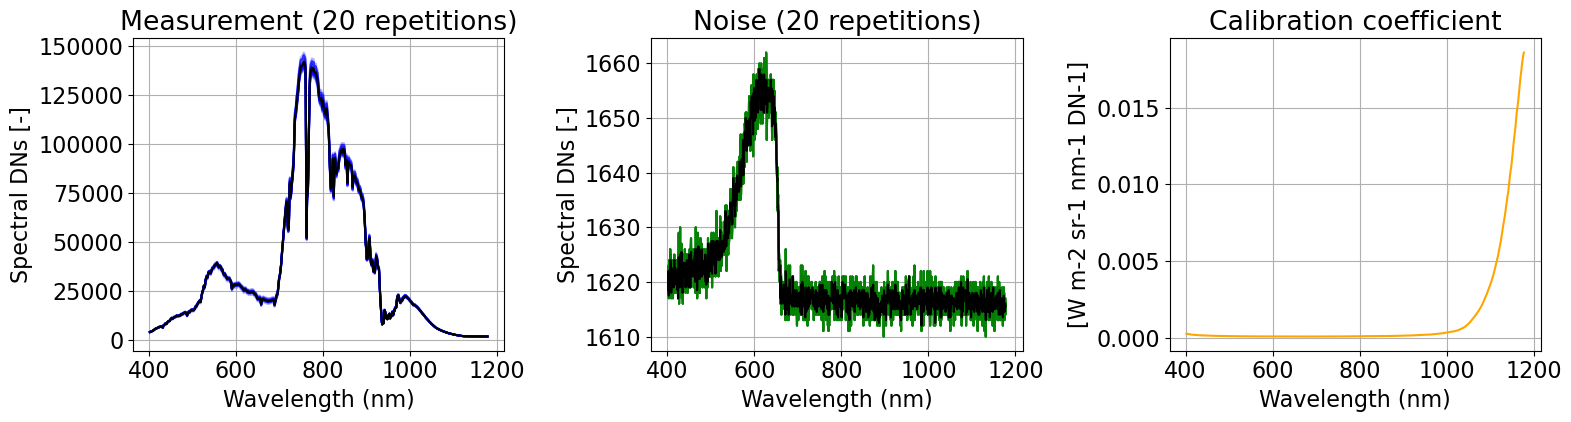

In [25]:
_, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True)
units = '%'

ax = axs[0]
ax.plot(Wvl, DataL0_Rad, 'b', alpha=0.3)
ax.plot(Wvl, DataL0_Rad.mean(axis=1), 'k')
ax.set_title(f'Measurement ({N_L} repetitions)')
ax.set_ylabel('Spectral DNs [-]')

ax = axs[1]
ax.plot(Wvl, Datadark_Rad, 'g', alpha=0.3)
ax.plot(Wvl, Datadark_Rad.mean(axis=1), 'k')
ax.set_title(f'Noise ({M_L} repetitions)')
ax.set_ylabel('Spectral DNs [-]')

ax = axs[2]
ax.plot(Wvl, cal_coef_L0, 'orange')
ax.set_title(f'Calibration coefficient')
ax.set_ylabel('[W m-2 sr-1 nm-1 DN-1]')

for ax in axs:
    ax.set_xlabel("Wavelength (nm)")
    ax.grid()

#### Irradiance (E)

In [26]:
# data for Irradiance sensor
DataE0_Irrad = data['S2_lg_Irrad']
N_E = DataE0_Irrad.shape[1]
print(N_E, 'repetitions of light measurements')

Datadark_Irrad = data['S2_dk_Irrad']
M_E = Datadark_Irrad.shape[1]
print(M_E, 'repetitions of dark measurements')

IT_Irrad = data['S2_IT_Irrad']
print(IT_Irrad, 'ms integration time')

cal_coef_E0 = data['CcalS2_E'] 

20 repetitions of light measurements
20 repetitions of dark measurements
58.0 ms integration time


<span style="color:red">
Plot the irradiance measurement, noise and calibration coefficient
</span>

## L and E

The raw readings of the instrument for reflectance components L and E


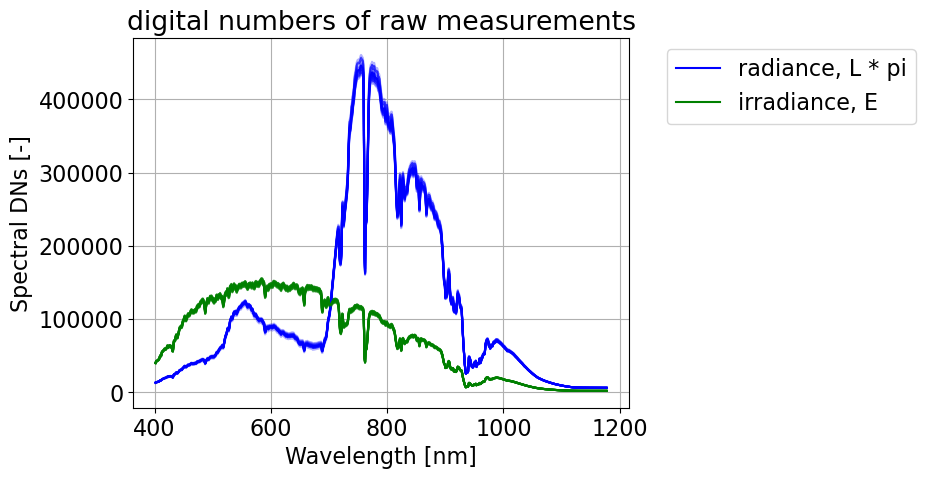

In [27]:
fig, ax = plt.subplots()

ax.plot(Wvl, DataL0_Rad * pi, 'b', alpha=0.3)
ax.plot(Wvl, DataE0_Irrad, 'g', alpha=0.3)

ax.plot(Wvl, DataL0_Rad.mean(axis=1) * pi, 'b', label='radiance, L * pi')
ax.plot(Wvl, DataE0_Irrad.mean(axis=1), 'g', label='irradiance, E')

ax.set_ylabel('Spectral DNs [-]')
ax.set_xlabel('Wavelength [nm]')
ax.grid()
ax.set_title('digital numbers of raw measurements')

ax.legend(bbox_to_anchor=(1.6, 1))

## 2-2 
## Integration time correction

[back to TOC](#TOC)

In [28]:
IT_Rad, IT_Irrad

(array(65.), array(58.))

In [29]:
def integration_time_normalisation(DN, IT):
    return DN / IT 

In [30]:
L0 = integration_time_normalisation(DataL0_Rad, IT_Rad)
dark_L0 = integration_time_normalisation(Datadark_Rad, IT_Rad)

E0 = integration_time_normalisation(DataE0_Irrad, IT_Irrad)
dark_E0 = integration_time_normalisation(Datadark_Irrad, IT_Irrad)

this is the time to average measurements

later we are going to compute radom uncertainty from this repetitions but now we keep them as is

In [31]:
L0_m = np.mean(L0, axis=1)
dark_L0_m = np.mean(dark_L0, axis=1)

E0_m = np.mean(E0, axis=1)
dark_E0_m = np.mean(dark_E0, axis=1)

### Reflectance
Now, having the radiance and irradiance data in DN we can derive the relative reflectance as ratio between pi*L/E.

In [32]:
def deriveR(L, E):
    return  (pi * L) / E

In [33]:
R0_rel = deriveR(L0_m, E0_m)
R0_rel.shape

(1036,)

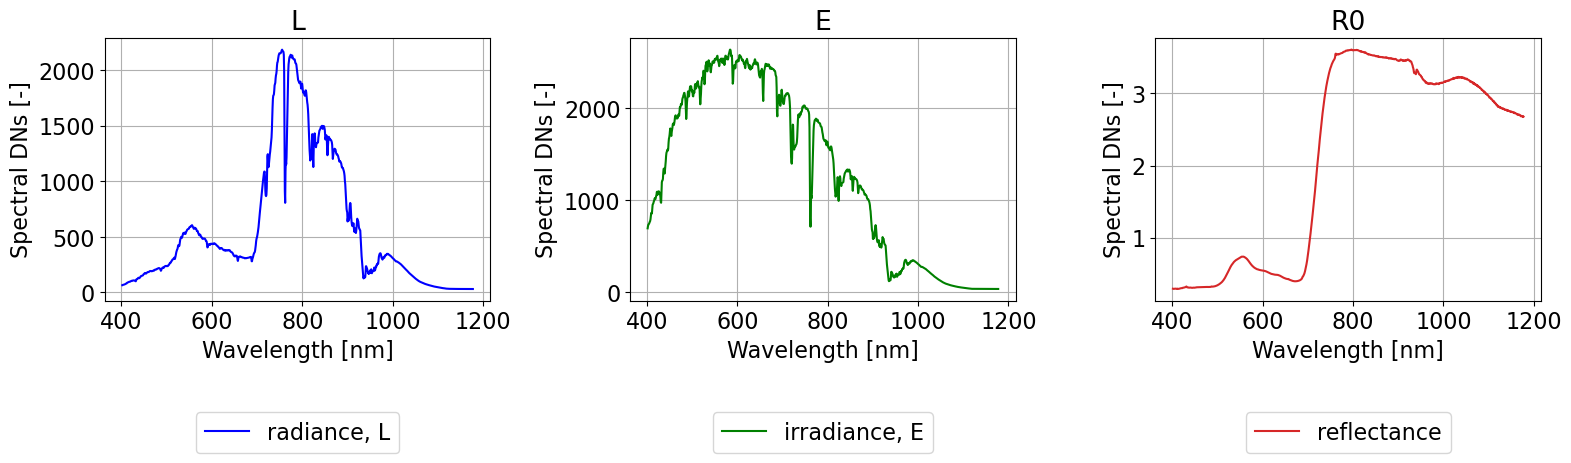

In [34]:
_, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True, sharex=True)

ax = axs[0]
ax.plot(Wvl, L0_m, 'b', label='radiance, L')
ax.set_title('L')

ax = axs[1]
ax.plot(Wvl, E0_m, 'g', label='irradiance, E')
ax.set_title('E')

ax = axs[2]
ax.plot(Wvl, R0_rel, 'tab:red', label='reflectance')
ax.set_title('R0')

for ax in axs:
    ax.set_ylabel('Spectral DNs [-]')
    ax.set_xlabel('Wavelength [nm]')
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

<span style="color:red">
Do you notice anything strange about the R0 reflectance?
</span>

## 2-3 
## Calibration coefficients application and nark noise subtraction
**the calibration functions for radiance and irradiance sensors**

[back to TOC](#TOC)

In [35]:
def calibrate(light_meas, dark_meas, cal_coef):
    return (light_meas - dark_meas) * cal_coef

In [36]:
L1 = calibrate(L0_m, dark_L0_m, cal_coef_L0) # calibration coefficients for signal without nonlin applied

E1 = calibrate(E0_m, dark_E0_m, cal_coef_E0) # calibration coefficients for signal without nonlin applied

R1_abs = deriveR(L1, E1)

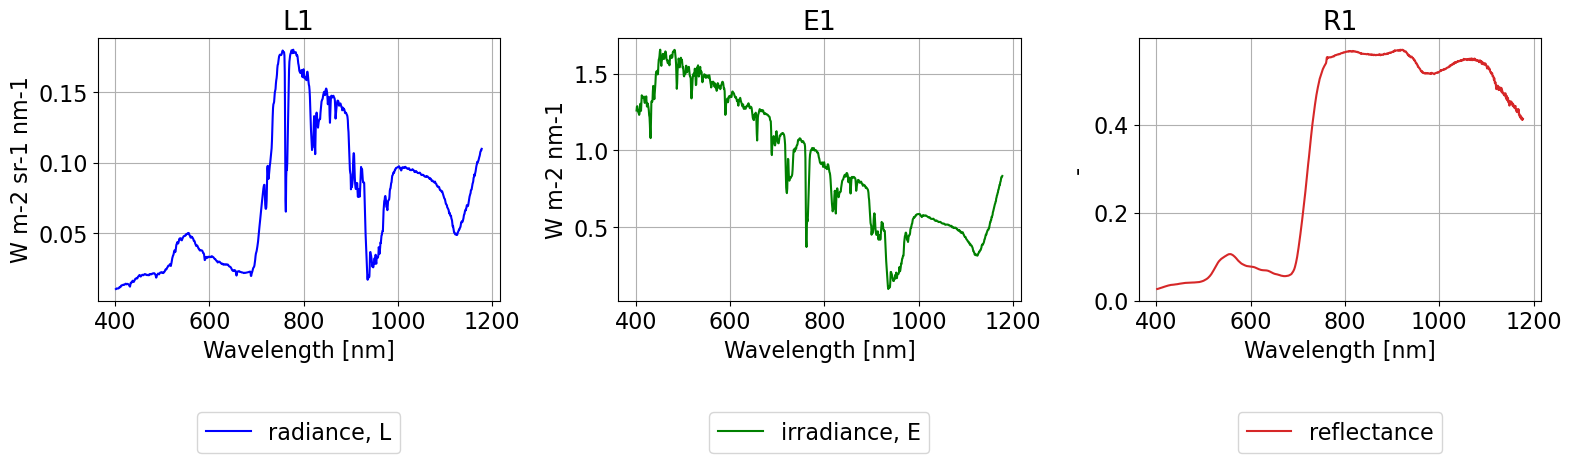

In [37]:
_, axs = plt.subplots(1, 3, figsize=(16, 4.5), tight_layout=True, sharex=True)

ax = axs[0]
ax.plot(Wvl, L1, 'b', label='radiance, L')
ax.set_title('L1')
ax.set_ylabel('W m-2 sr-1 nm-1')

ax = axs[1]
ax.plot(Wvl, E1, 'g', label='irradiance, E')
ax.set_title('E1')
ax.set_ylabel('W m-2 nm-1')

ax = axs[2]
ax.plot(Wvl, R1_abs, 'tab:red', label='reflectance')
ax.set_title('R1')
ax.set_ylabel('-')

for ax in axs:
    ax.set_xlabel('Wavelength [nm]')
    ax.grid()
    ax.legend(bbox_to_anchor=[0.5, -0.5], loc='center')

<span style="color:red">
@Laura, Why so low numbers? Are those mW?
</span>